In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

In [2]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


# importing data
# Read the 2D array back from the text file

dir_path = "/kaggle/input/dp-5-30-2/d_big(-5_30)"
print(dir_path)
#print("Files in the directory:")
#print(os.listdir(dir_path))

data_needed = {'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}

event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}
event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}
# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'
search_pattern = os.path.join(dir_path, f'*{search_string}*')
#print(search_pattern)
matching_files = glob.glob(search_pattern)
#print(matching_files)

X_data = []
Y_data = []

for file in matching_files:
    event_type, event_name = os.path.basename(file).split('_')
    if (event_type== "DISTPAR"):
        continue
        
    if event_counter[event_type] < data_needed[event_type]:
        loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)
        X_data.append(loaded_data)
    
        y = [0,0,0,0]
        for key,value in event_types.items():
            if value in file.split('\\')[-1]:
                #print(value, file)
                y[key-1] = 1
                Y_data.append(y)
                event_counter[value] += 1
                break
 
    if all(count >= 400 for count in event_counter.values()):
        break
            
print(event_counter)  
X_data = np.array(X_data)
Y_data = np.array(Y_data)
print(X_data.shape)
print(Y_data.shape)

/kaggle/input/dp-5-30-2/d_big(-5_30)


/tmp/ipykernel_34/1223904279.py:35: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  loaded_data = np.loadtxt(file, dtype=np.int16, delimiter='\t').astype(np.int16)


{'GRB': 800, 'TGF': 800, 'SGR': 400, 'SFLARE': 800}
(2800, 45955)
(2800, 4)


In [3]:
import imblearn
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X_balanced, Y_balanced = oversample.fit_resample(X_data, Y_data)
print(X_balanced.shape)
print(Y_balanced.shape)
print(X_data.shape)
print(Y_data.shape)

(3200, 45955)
(3200, 4)
(2800, 45955)
(2800, 4)


In [4]:
from sklearn.model_selection import train_test_split

print("X_balanced shape : ",X_balanced.shape)
print("Y_balanced_shape : ",Y_balanced.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_balanced, Y_balanced, test_size = 0.25,stratify=Y_balanced)#, random_state=42)
print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("Y_train shape",Y_train.shape)
print("Y_test shape",Y_val.shape)
print(X_data.shape)

X_balanced shape :  (3200, 45955)
Y_balanced_shape :  (3200, 4)
X_train shape (2400, 45955)
X_test shape (800, 45955)
Y_train shape (2400, 4)
Y_test shape (800, 4)
(2800, 45955)


In [7]:
import tensorflow as tf
from keras import layers, models,regularizers
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, Callback

tf.random.set_seed(42)


# Build the CNN model
model = models.Sequential()
model.add(layers.Conv1D(64, 4, activation='relu', input_shape=(X_train.shape[1:])+tuple([1]),kernel_regularizer=regularizers.l2(0.04)))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D((5)))
model.add(layers.Conv1D(32,1, activation='relu',kernel_regularizer=regularizers.l2(0.04)))
model.add(layers.MaxPooling1D((5)))



model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.03)))
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.03)))
model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.03)))
model.add(layers.Dense(4, activation='softmax',kernel_regularizer=regularizers.l2(0.02)))
model.summary()
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
#custom_early_stopping = CustomEarlyStopping(monitor_train='accuracy', monitor_val='val_accuracy', threshold=0.85, verbose=1)

epoch = 90
# Train the model
history = model.fit(X_train, Y_train, epochs=epoch, batch_size=64, validation_data=(X_val, Y_val))#,callbacks=[custom_early_stopping])

# Evaluate the model on the test set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print(f'\n accuracy on training data: {train_acc} \n \n')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, Y_val, verbose=2)
print(f'accuracy on test data: {test_acc}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 58816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,764,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,773,060 (14.39 MB)

 Trainable params: 3,773,060 (14.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.3503 - loss: 21.0146 - val_accuracy: 0.5638 - val_loss: 7.0660
Epoch 2/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.5537 - loss: 7.0721 - val_accuracy: 0.6950 - val_loss: 5.6966
Epoch 3/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.6987 - loss: 5.4851 - val_accuracy: 0.6413 - val_loss: 4.8895
Epoch 4/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.7219 - loss: 4.7305 - val_accuracy: 0.7613 - val_loss: 4.2819
Epoch 5/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.7456 - loss: 4.2410 - val_accuracy: 0.7825 - val_loss: 3.9172
Epoch 6/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.7593 - loss: 3.9049 - val_accuracy: 0.7763 - val_loss: 3.6703
Epoch 7/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.7801 - loss: 3.6480 - val_accuracy: 0.7775 - val_loss: 3.4751
Epoch 8/90
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.7726 - loss: 3.4624 - val_acc

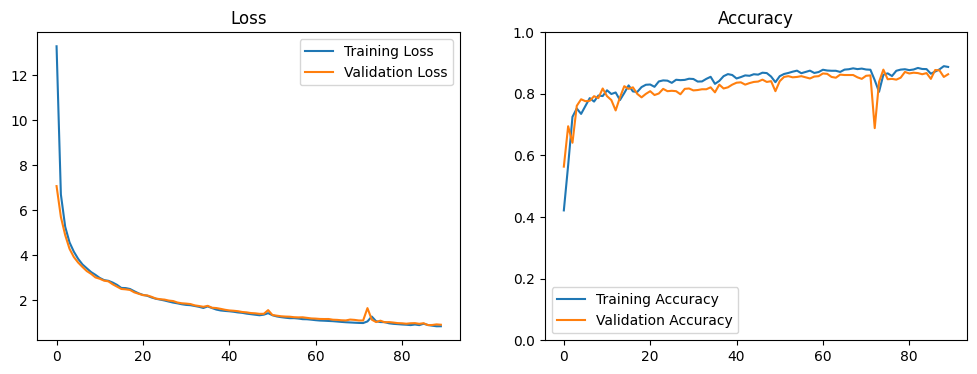

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.ylim(0, 1) 
plt.show()

In [15]:
import json

# Save the model
model.save('/kaggle/working/saved_(-5_30)_balanced_final.h5')

# Save additional details using JSON
details = {
    'dataset': '(-5_30)_2m',
    'data' : [800,800,400,800],
    'architecture': 'CNN_balaced with SMOTE',
    'parameters': {
        'epochs': 90,
        'batch_size': 64,
        'learning_rate': 0.001,
        'l2_regularizers':['0.04_conv','0.03_dense','0.02_softmax'],
        'kernel_size':4,
        'filters':{
            'input_layer':64,
            'first_conv':32
        },
        'v_acc': 0.8637499809265137,
        't_acc': 0.8820833563804626,
        'Dense_layers': [64,64,32,4],
        'r,w,u' : [75.9,3.5,20.5]
    }
}

with open('/kaggle/working/model_detail_balanced_final.json', 'w') as f:
    json.dump(details, f)


In [11]:
from keras.models import load_model

lmodel_2 = load_model(r"/kaggle/working/saved_(-5_30)_balanced_new1.h5")
lmodel_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 45952, 64)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9190, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9190, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1838, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 58816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     3,764,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,773,062 (14.39 MB)

 Trainable params: 3,773,060 (14.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [19]:
def model_conf_u(model,X,Y,conf_threshold = 0.6):
    conf=[]
    a = 0
    w = 0
    uncert = 0

    for n in range(len(Y)):
        
        x = X[n].reshape(1, X[n].shape[0], 1)
        y = Y[n].tolist()

        y_pred = model.predict(x, verbose = 0).tolist()[0]

        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if max_value > conf_threshold:
            if y.index(max(y)) == max_index:
                conf.append(max_value)
                a = a+1
            else:
                w = w+1
        else:
            uncert = uncert+1
    
    print('confidently right', a/len(Y))
    print('confidently wrong', w/len(Y))
    print('uncertain', uncert/len(Y))

model_conf_u(lmodel_2,X_balanced,Y_balanced,0.6)

confidently right 0.7590625
confidently wrong 0.0353125
uncertain 0.205625


In [18]:
def model_conf(model, X, Y, conf_threshold=0.6):
    conf_right = []
    conf_wrong = []

    for n in range(len(Y)):
        x = X[n].reshape(1, X[n].shape[0], 1)  # Reshape each data point to (1, 45955, 1)

        y = Y[n].tolist()
        y_pred = model.predict(x, verbose=0).tolist()[0]
        
        max_value = y_pred[0]
        max_index = 0

        for i, value in enumerate(y_pred):
            if value > max_value:
                max_value = value
                max_index = i

        if y.index(max(y)) == max_index and max_value > conf_threshold:
            conf_right.append(max_value)
        else:
            conf_wrong.append(max_value)            

    return len(conf_right) / (len(conf_right) + len(conf_wrong)), conf_right, conf_wrong

a,r,w = model_conf(lmodel_2,X_balanced,Y_balanced,0.6)

print(a)
print('average conf when right',sum(r)/len(r))
print('average conf when wrong',sum(w)/len(w))

0.7590625
average conf when right 0.8994344070204102
average conf when wrong 0.5135580477161011


In [22]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import classification_report

def model_with_undetermined_class(model, X, conf_threshold=0.3):
    new_class_predictions = []
    
    for n in range(len(X)):
        x = X[n].reshape(1, X[n].shape[0], 1)
        y_pred = model.predict(x, verbose=0)[0]
        
        max_index = np.argmax(y_pred)
        max_value = y_pred[max_index]
        
        if max_value < conf_threshold:
            new_class_predictions.append(4)  # undetermined class
        else:
            new_class_predictions.append(max_index)
    
    return np.array(new_class_predictions)

new_predictions = model_with_undetermined_class(lmodel_2, X_balanced, 0.3)

print(f'Number of undetermined classifications: {(new_predictions == 4).sum()}')


Number of undetermined classifications: 12


In [42]:
# truth labels to single class index
true_labels = np.argmax(Y_balanced, axis=1)

print(classification_report(true_labels, new_predictions, labels=[0, 1, 2, 3], target_names=['GRB', 'TGF', 'SGR', 'SFLARE'], zero_division=0))

              precision    recall  f1-score   support

         GRB       0.91      0.74      0.81       800
         TGF       0.84      0.98      0.91       800
         SGR       0.87      0.95      0.91       800
      SFLARE       0.92      0.83      0.87       800

   micro avg       0.88      0.88      0.88      3200
   macro avg       0.88      0.88      0.88      3200
weighted avg       0.88      0.88      0.88      3200

